# Prepare regression models
- You can create a new regression model with your original database
- Algorithms are basically based on the following paper
    - https://pubs.acs.org/doi/10.1021/jacs.9b11442

# Load settings
- Most global settings are set in "settings.yaml"
    - TODO: Some codes do not refer "setting_path" in the notebook
      - path is given (hard-coded) as "setting.yaml" in some modules

In [2]:
import joblib
import yaml
import sys
%load_ext autoreload
%autoreload 2

sys.path.append("ion_manager/ion_predictor")
from ion_manager.ion_predictor.ml.auto_trainer import auto_prepare_model
from ion_manager.ion_predictor.ml import pretrain_descriptors


# load global settings
setting_path = "settings.yaml"
with open(setting_path) as file:
    settings = yaml.safe_load(file)


# Train GNN
- You don't always have to run these codes

# Dump pretraining descriptor data from SMILES data
- it takes time
- you can tune the number of training molecules by changing "num_learning_molecules" in setting.yaml

In [5]:

pretrain_descriptors.dump(settings)


100%|██████████| 300/300 [00:55<00:00,  5.45it/s]


# Train gnn model
- Some hyperparams can be changed at settings yaml
- The trained neural net is saved in the cache folder
- The code is for CPU, but you can accelerate it by GPU with code modification

/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
 10%|█         | 21/200 [00:02<00:19,  9.16it/s]

Epoch 20, loss 0.6768


 20%|██        | 41/200 [00:04<00:17,  8.98it/s]

Epoch 40, loss 0.5965


 30%|███       | 61/200 [00:06<00:15,  8.91it/s]

Epoch 60, loss 0.5887


 40%|████      | 81/200 [00:09<00:13,  8.71it/s]

Epoch 80, loss 0.5471


 50%|█████     | 101/200 [00:11<00:11,  8.78it/s]

Epoch 100, loss 0.5212


 60%|██████    | 121/200 [00:13<00:09,  8.72it/s]

Epoch 120, loss 0.4976


 70%|███████   | 141/200 [00:16<00:06,  8.67it/s]

Epoch 140, loss 0.4889


 80%|████████  | 161/200 [00:18<00:04,  8.85it/s]

Epoch 160, loss 0.4683


 90%|█████████ | 181/200 [00:20<00:02,  8.91it/s]

Epoch 180, loss 0.4695


100%|██████████| 200/200 [00:22<00:00,  8.82it/s]

Epoch 200, loss 0.4601


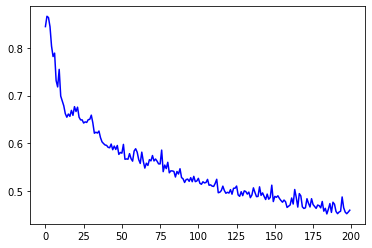

In [6]:

auto_prepare_model(settings)


# Prepare regression model
- You should run these codes to refresh a regression model with your custom database

In [3]:
from ion_manager.ion_predictor.composite.auto_data_preparer import load_ion_excel
import pandas as pd
from ion_manager.ion_predictor.ml.regressor import initiate_regressor
from ion_manager.ion_predictor.ml.dataset_utils import get_number_and_category_cols
from ion_manager.ion_predictor.django_wrapper.auto_predictor import compensate_columns


# load CSV data dumped by django

composite_path = "database/composite_train.csv"
composite_path = "database/composite_all.csv"       #train all: this contains data of composite_test in JACS2020
compound_path = "database/compounds.csv"

composite_df = pd.read_csv(composite_path)
compound_df = pd.read_csv(compound_path)

# calc neural descriptors etc
parsed_df = load_ion_excel(
    settings, compound_df=compound_df, composite_df=composite_df)


/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/data1/python/git/ion_predictor/ion_manager/ion_predictor/composite/DataUtility.py:115: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


In [4]:
# check for numeric and category caolumns

y_label = settings["y_label"]

X = parsed_df.drop([y_label, "ID"], axis=1)
X = X.sort_index(axis=1, ascending=False)

y = parsed_df[[y_label]]


# default model is a pipeline of imputers, scalers, and random forest regressor
number_columns, category_columns = get_number_and_category_cols(
    parsed_df, y_label)
model = initiate_regressor(number_columns, category_columns)

# fit
model.fit(X, y)

# dump model for django
joblib.dump([model, list(X.columns)], settings["regressor_path"])


/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


['cache/regressor.bin']

# Check prediction

In [5]:
import numpy as np
composite_test_path = "database/composite_test.csv"
composite_df = pd.read_csv(composite_test_path)

test_df = load_ion_excel(
    settings, compound_df=compound_df, composite_df=composite_df)


# add some lacking columns emerged during preprocessing processes
test_X = test_df.drop([y_label, "ID"], axis=1)
test_X = compensate_columns(test_X, X.columns)

test_y = test_df[[y_label]]


/home/user/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/data1/python/git/ion_predictor/ion_manager/ion_predictor/composite/DataUtility.py:115: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


Text(-10, -1, 'MAE: 0.15')

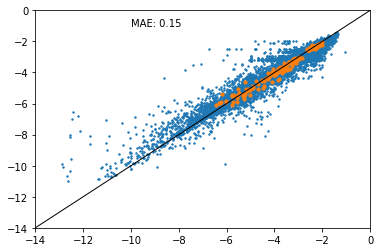

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score


ax = plt
pred_train_y = model.predict(X)
pred_test_y = model.predict(test_X)

ax.scatter(y, pred_train_y, s=2)
ax.scatter(test_y, pred_test_y, s=10)
plt.xlim(-14, 0)
plt.ylim(-14, 0)
ax.plot((-14, 0), (-14, 0), c="black", linewidth=1)

test_mae = mean_absolute_error(test_y, pred_test_y)
ax.text(-10, -1, f"MAE: {test_mae:.2f}")
